In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torch import nn

import torch.nn.functional as F

data_dir = "dataset"
batch_size = 16

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("selected device: ", device)

train_dataset = torchvision.datasets.CIFAR10(data_dir, train=True, download=True)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

train_dataset.transform = train_transform
m=len(train_dataset)
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)


class Encoder(nn.Module):

	def __init__(self, latent_dim):
		super(Encoder, self).__init__()

		self.cnn = nn.Sequential(
			nn.Conv2d(3, 128, 3, stride=2, padding=1),
			nn.BatchNorm2d(128),
			nn.ELU(True),
			nn.Conv2d(128, 256, 3, stride=2, padding=1),
			nn.BatchNorm2d(256),
			nn.ELU(True),
			nn.Conv2d(256, 512, 3, stride=2, padding=0),
			nn.BatchNorm2d(512),
			nn.ELU(True),
		)

		self.flatten = nn.Flatten(start_dim=1)

		self.fc = nn.Sequential(
			nn.Linear(3 * 3 * 512, 128),
			nn.ELU(True),
			nn.Linear(128, latent_dim)
		)

	def forward(self, x):
		x = self.cnn(x)
		# print("enc: ", x.shape)
		x = self.flatten(x)
		x = self.fc(x)
		return x


class Decoder(nn.Module):

	def __init__(self, latent_dim):
		super(Decoder, self).__init__()

		self.fc = nn.Sequential(
			nn.Linear(latent_dim, 128),
			nn.BatchNorm1d(128),
			nn.ELU(True),
			nn.Linear(128, 3 * 3 * 512),
			nn.BatchNorm1d(3 * 3 * 512),
			nn.ELU(True)
		)

		self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 3, 3))

		self.deconv = nn.Sequential(
			nn.ConvTranspose2d(512, 256, 4, stride=2, output_padding=0),
			nn.BatchNorm2d(256),
			nn.ELU(True),
			nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
			nn.BatchNorm2d(128),
			nn.ELU(True),
			nn.ConvTranspose2d(128, 3, 3, stride=2, padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.fc(x)
		x = self.unflatten(x)
		x = self.deconv(x)
		x = torch.sigmoid(x)
		return x
    

class EncoderSmall(nn.Module):

	def __init__(self, latent_dim):
		super(EncoderSmall, self).__init__()

		self.cnn = nn.Sequential(
			nn.Conv2d(3, 5, 3, stride=2, padding=1),
			nn.BatchNorm2d(5),
			nn.ELU(True),
			nn.Conv2d(5, 5, 3, stride=2, padding=1),
			nn.BatchNorm2d(5),
			nn.ELU(True),
			nn.Conv2d(5, 5, 3, stride=2, padding=0),
			nn.BatchNorm2d(5),
			nn.ELU(True),
		)

		self.flatten = nn.Flatten(start_dim=1)

		self.fc = nn.Sequential(
			nn.Linear(3 * 3 * 5, 128),
			nn.ELU(True),
			nn.Linear(128, latent_dim)
		)

	def forward(self, x):
		x = self.cnn(x)
		# print("enc: ", x.shape)
		x = self.flatten(x)
		x = self.fc(x)
		return x


class DecoderSmall(nn.Module):

	def __init__(self, latent_dim):
		super(DecoderSmall, self).__init__()

		self.fc = nn.Sequential(
			nn.Linear(latent_dim, 5),
			nn.BatchNorm1d(5),
			nn.ELU(True),
			nn.Linear(5, 3 * 3 * 5),
			nn.BatchNorm1d(3 * 3 * 5),
			nn.ELU(True)
		)

		self.unflatten = nn.Unflatten(dim=1, unflattened_size=(5, 3, 3))

		self.deconv = nn.Sequential(
			nn.ConvTranspose2d(5, 5, 4, stride=2, output_padding=0),
			nn.BatchNorm2d(5),
			nn.ELU(True),
			nn.ConvTranspose2d(5, 5, 3, stride=2, padding=1, output_padding=1),
			nn.BatchNorm2d(5),
			nn.ELU(True),
			nn.ConvTranspose2d(5, 3, 3, stride=2, padding=1, output_padding=1)
		)

	def forward(self, x):
		x = self.fc(x)
		x = self.unflatten(x)
		x = self.deconv(x)
		x = torch.sigmoid(x)
		return x


class AE(nn.Module):
    def __init__(self, small=True):
        super(AE, self).__init__()
        d = 256
        self.encoder = EncoderSmall(latent_dim=d).to(device) if small else EncoderSmall(latent_dim=d).to(device) 
        self.decoder = DecoderSmall(latent_dim=d).to(device) if small else Decoder(latent_dim=d).to(device)
    
    def forward(self, batch):
        latent = self.encoder(batch)
        x_recover = self.decoder(latent)
        return x_recover
    
    def loss(self, batch):
        with torch.no_grad():
            x_rec = self(batch)
            loss = torch.nn.functional.mse_loss(x_rec, batch).mean().item()
        return loss

        
torch.manual_seed(0)
data_batch, _ = next(iter(data_loader))
data_batch = data_batch.to(device)


model = AE().to(device)
target_model = AE().to(device)
target_model.load_state_dict(model.state_dict())

print(model.loss(data_batch))

# for p1, p2 in zip(model.parameters(), target_model.parameters()):
#     print(((p1.data - p2.data)**2).mean())

selected device:  cpu
Files already downloaded and verified
0.0735805556178093


In [2]:
scale = 1
vec1, vec2 = [], []

for param in model.parameters():
    norm_fro = torch.norm(param.data)
    
    w1 = torch.randn_like(param.data)
    w1 = norm_fro * w1 / torch.norm(w1) 
    vec1.append(w1)
    
    w2 = torch.randn_like(param.data)
    w2 = norm_fro * w2 / torch.norm(w2) 
    vec2.append(w2)
    
# for p1, p2 in zip(vec1, vec2):
#     print(((p1 - p2)**2).mean())

In [3]:
def get_loss_at(batch, alpha, beta):
    target_param = []
    for i, p in enumerate(model.parameters()):
        target_param.append(p + alpha * vec1[i] + beta * vec2[i])
        
    for target_param, param, v1, v2 in zip(target_model.parameters(), model.parameters(), vec1, vec2):
        new_param = param.data + alpha * v1 + beta * v2
        target_param.data.copy_(param.data + alpha * v1 + beta * v2)
                
    return target_model.loss(batch)
        
        
print(get_loss_at(data_batch, 100, 100))

0.3061751127243042


In [4]:
n = 100

a = np.linspace(-100, 100, n)
b = np.linspace(-100, 100, n)

landscape = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        landscape[i, j] = get_loss_at(data_batch, a[i], b[j])
        if i % 10 == 0 and j % 10 == 0:
            print(i, j)

print("finish")

0 0
0 10
0 20
0 30
0 40
0 50
0 60
0 70
0 80
0 90
10 0
10 10
10 20
10 30
10 40
10 50
10 60
10 70
10 80
10 90
20 0
20 10
20 20
20 30
20 40
20 50
20 60
20 70
20 80
20 90
30 0
30 10
30 20
30 30
30 40
30 50
30 60
30 70
30 80
30 90
40 0
40 10
40 20
40 30
40 40
40 50
40 60
40 70
40 80
40 90
50 0
50 10
50 20
50 30
50 40
50 50
50 60
50 70
50 80
50 90
60 0
60 10
60 20
60 30
60 40
60 50
60 60
60 70
60 80
60 90
70 0
70 10
70 20
70 30
70 40
70 50
70 60
70 70
70 80
70 90
80 0
80 10
80 20
80 30
80 40
80 50
80 60
80 70
80 80
80 90
90 0
90 10
90 20
90 30
90 40
90 50
90 60
90 70
90 80
90 90
finish


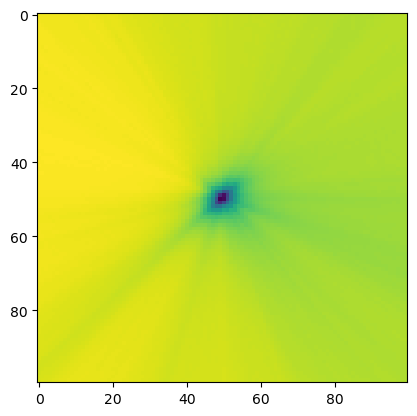

In [5]:
plt.imshow(landscape)